In [42]:
# import necessary libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import os
import plotly.express as px
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import boxcox

## Question 1

### Question 1.1


In [2]:
df = pd.read_csv('monthly_tourists.csv')
df.head()

,Date,Visits
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
#Convert Date to datetime 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
# Set 'Date' as the index
df.head()

,Visits
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


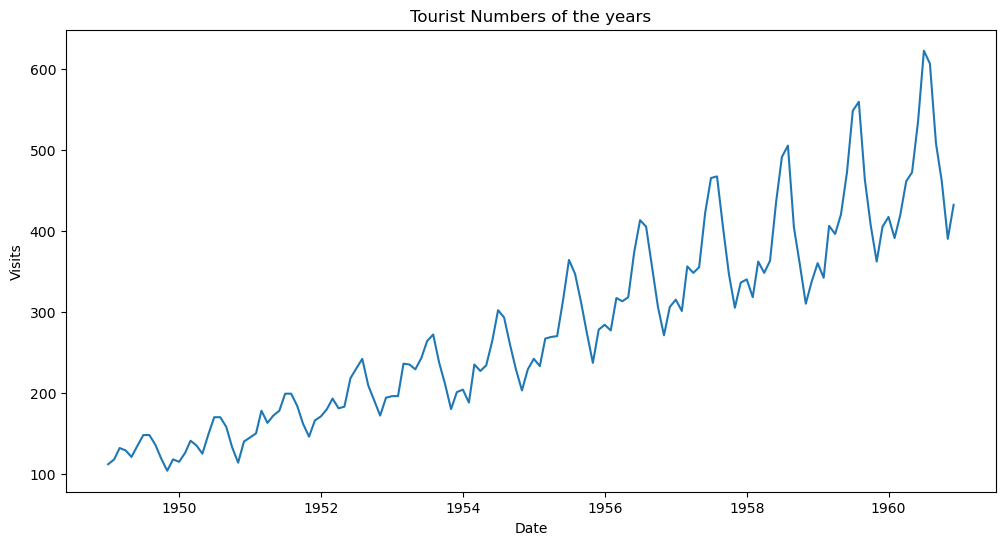

In [5]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df['Visits'])
plt.title('Tourist Numbers of the years')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.show()


## Analysis of Graphs
 - Strong upward growth with clear seasonal fluctuactions showing over the time period


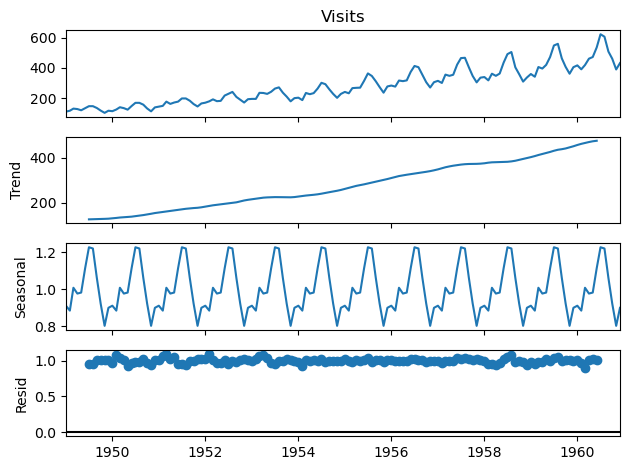

In [6]:
# Decomposition
decomposition = seasonal_decompose(df['Visits'], model='multiplicative', period=12)
fig = decomposition.plot()
plt.show()


## Trend Analysis
- There ia a clear upward trend
- Nearly Linear Growth Pattern
## Seasonal Analysis
- Regular repeating pattern of 12 months
- Likely corresponds to summer holidays, school breaks, and optimal safari weather
## Residuals Analysis
-  Residuals are relatively small and randomly distributed around 1.0
-  A few minor outliers visible but nothing extreme
### Strong trend and seasonality make Holt-Winters triple exponential smoothing ideal




## Question 1.2


In [7]:
# Split data into train and test sets
train = df[:-12]  
test= df[-12:]

In [8]:
# Set index for 'ES-Fitted' Column
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]
n_test = len(test_idx)


In [9]:
# Instantiation (trend='add', seasonal='add')
model = ExponentialSmoothing(train['Visits'], trend='add', seasonal='mul', seasonal_periods=12)

C:\Users\zinya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [10]:
# Fit the Model
res_model= model.fit()
print(res_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Visits   No. Observations:                  132
Model:             ExponentialSmoothing   SSE                          12594.614
Optimized:                         True   AIC                            633.685
Trend:                         Additive   BIC                            679.810
Seasonal:                Multiplicative   AICC                           639.738
Seasonal Periods:                    12   Date:                 Mon, 03 Nov 2025
Box-Cox:                          False   Time:                         09:16:45
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3762178                alpha                 True
smoothing_trend          

In [11]:
#Display optimized parameters
print("OPTIMIZED MODEL PARAMETERS:")
print(f"Smoothing Level (Alpha - α):     {res_model.params['smoothing_level']:.6f}")
print(f"Smoothing Trend (Beta - β):      {res_model.params['smoothing_trend']:.6f}")
print(f"Smoothing Seasonal (Gamma - γ):  {res_model.params['smoothing_seasonal']:.6f}")
print(f"Initial Level:                    {res_model.params['initial_level']:.4f}")
print(f"Initial Trend:                    {res_model.params['initial_trend']:.4f}")


OPTIMIZED MODEL PARAMETERS:
Smoothing Level (Alpha - α):     0.376218
Smoothing Trend (Beta - β):      0.000000
Smoothing Seasonal (Gamma - γ):  0.623782
Initial Level:                    109.2475
Initial Trend:                    2.6451


In [12]:
# Calculate FittedValues and Forecast for Holt-Winters Column
df.loc[train_idx, 'Holt-Winters'] = res_model.fittedvalues
df.loc[test_idx, 'Holt-Winters'] = res_model.forecast(n_test)

In [58]:
# Forecast for test period (12 months)
forecast_test = res_model.forecast(steps=12)
forecast_test

1960-01-01    417.284970
1960-02-01    394.061329
1960-03-01    462.443466
1960-04-01    448.597065
1960-05-01    471.869294
1960-06-01    539.892440
1960-07-01    623.821734
1960-08-01    631.152970
1960-09-01    515.579605
1960-10-01    449.901028
1960-11-01    394.276467
1960-12-01    422.510676
Freq: MS, dtype: float64

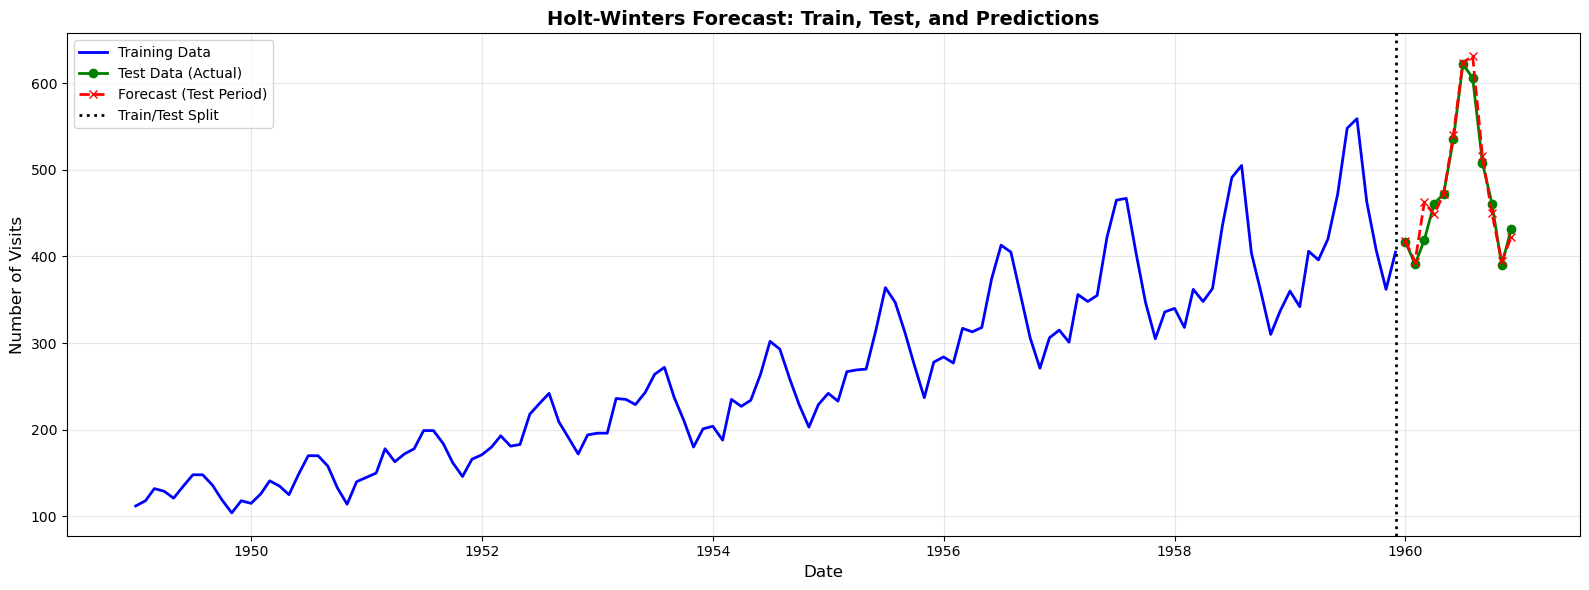

In [14]:
#Full view with train, test, and forecast
plt.figure(figsize=(16, 6))
plt.plot(train.index, train['Visits'], label='Training Data', linewidth=2, color='blue')
plt.plot(test.index, test['Visits'], label='Test Data (Actual)', linewidth=2, color='green', marker='o')
plt.plot(test.index, forecast_test, label='Forecast (Test Period)', linewidth=2, color='red', linestyle='--', marker='x')
plt.axvline(x=train.index[-1], color='black', linestyle=':', linewidth=2, label='Train/Test Split')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Visits', fontsize=12)
plt.title('Holt-Winters Forecast: Train, Test, and Predictions', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The model closely follows the seasonal pattern and trend of the data. In the forecast region, the predictions capture the up and down pattern quite well. Slight deviation is visible in the last few forecast points. indicating minor underestimation or over estimation near peaks. The model fits the training data very well and generalises decently to the test set.

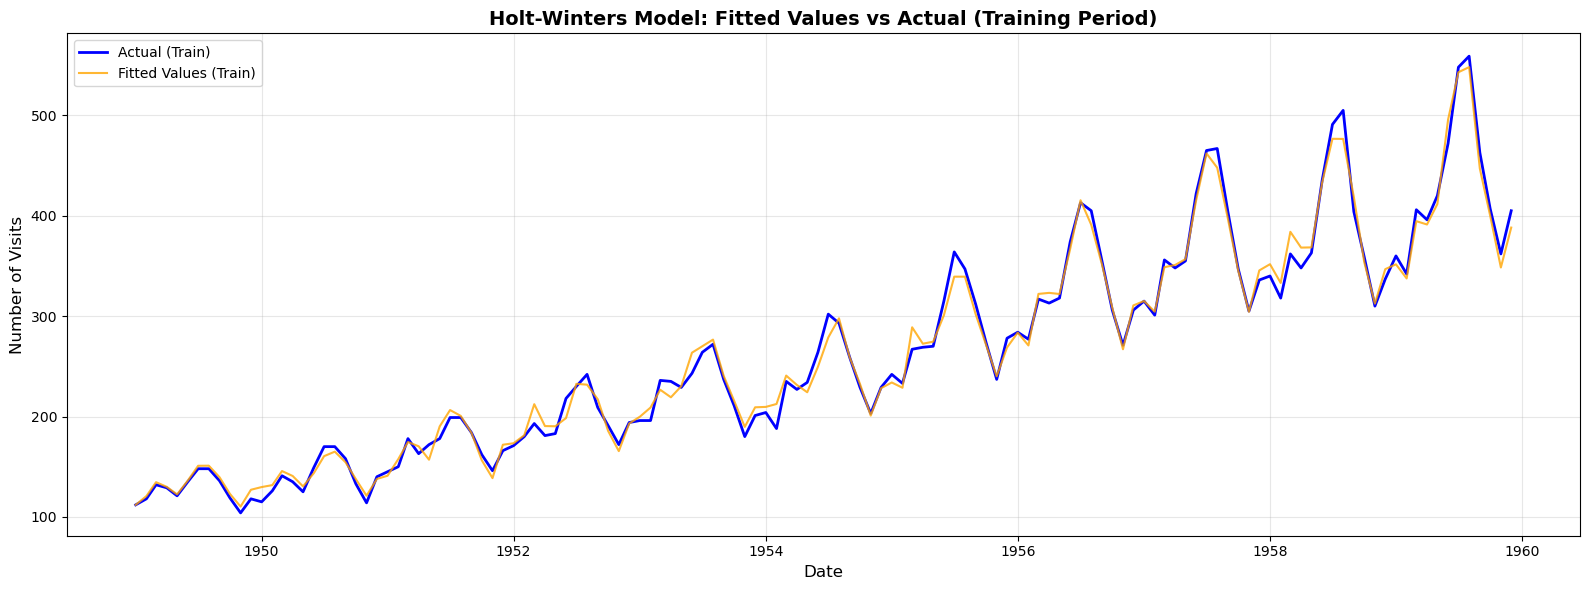

In [15]:
# Fitted values on training data
plt.figure(figsize=(16, 6))
plt.plot(train.index, train['Visits'], label='Actual (Train)', linewidth=2, color='blue')
plt.plot(train.index, res_model.fittedvalues, label='Fitted Values (Train)', linewidth=1.5, color='orange', alpha=0.8)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Visits', fontsize=12)
plt.title('Holt-Winters Model: Fitted Values vs Actual (Training Period)', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The fitted line almost perfectly overlaps the actual line, indicating that the model learned thetrend and seasonality during training. The model is well optimized and overfitting does not appear to be severe.

In [16]:
# Residual analysis
residuals_train = train['Visits'] - res_model.fittedvalues
residuals_test = test['Visits'] - forecast_test

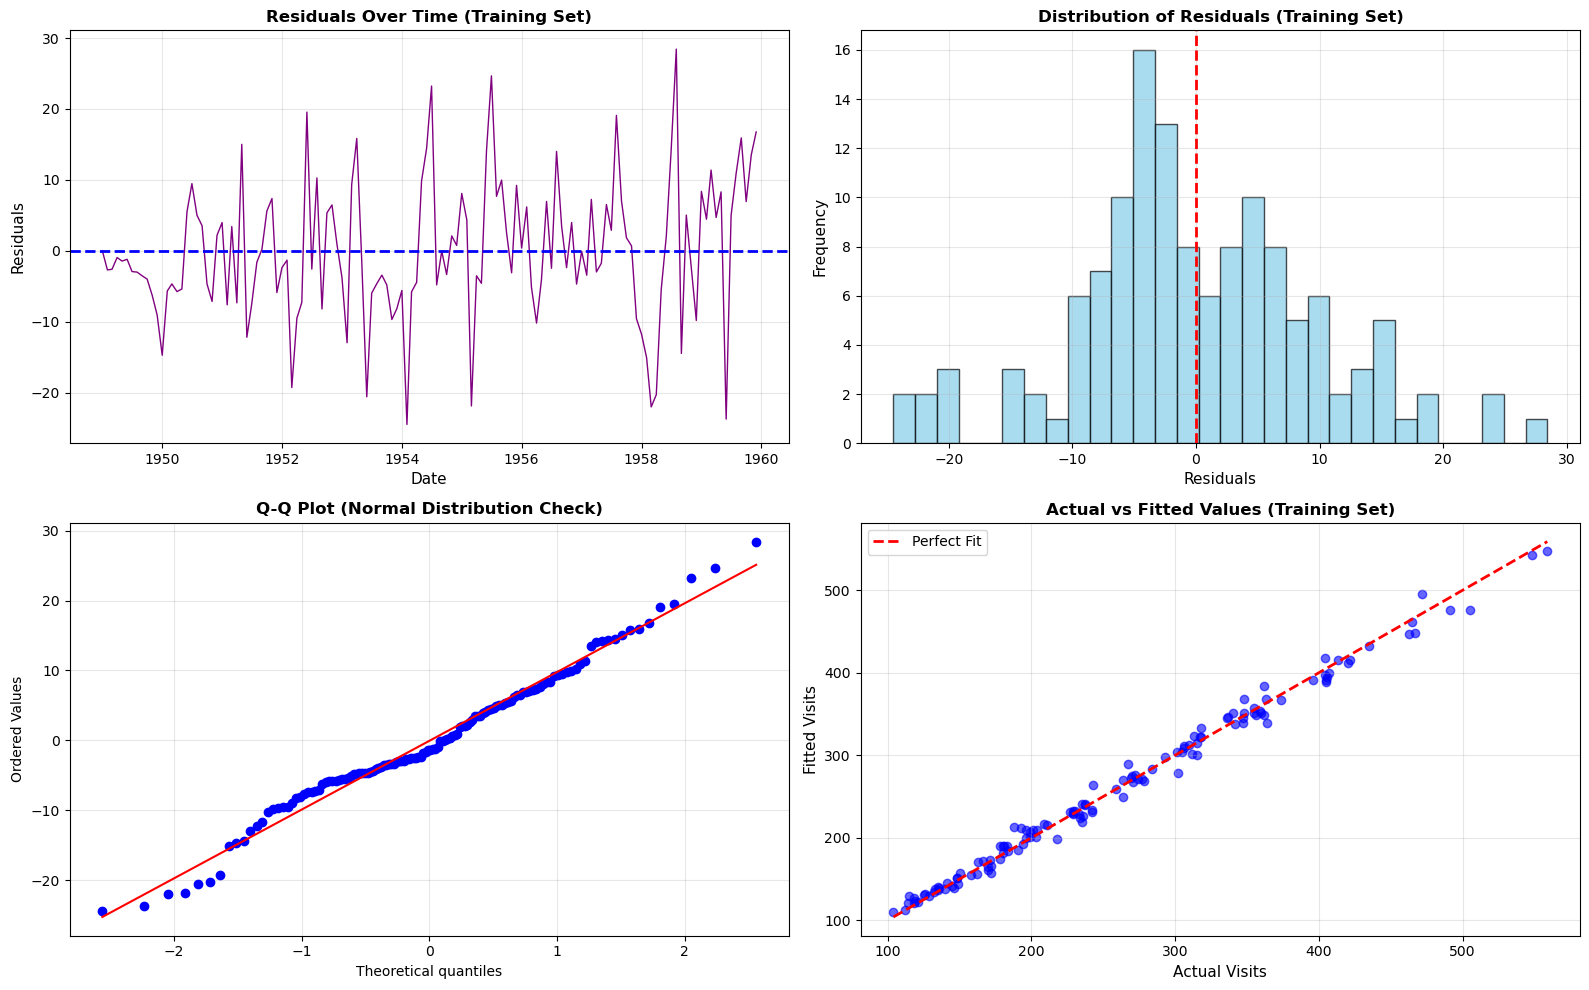

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
#  Residuals over time (Training)
axes[0, 0].plot(train.index, residuals_train, color='purple', linewidth=1)
axes[0, 0].axhline(y=0, color='blue', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Residuals Over Time (Training Set)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histogram of residuals
axes[0, 1].hist(residuals_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Residuals (Training Set)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

#Q-Q Plot
from scipy import stats
stats.probplot(residuals_train, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normal Distribution Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Actual vs Fitted (Training)
axes[1, 1].scatter(train['Visits'], res_model.fittedvalues, alpha=0.6, color='blue')
axes[1, 1].plot([train['Visits'].min(), train['Visits'].max()], 
                [train['Visits'].min(), train['Visits'].max()], 
                'r--', linewidth=2, label='Perfect Fit')
axes[1, 1].set_xlabel('Actual Visits', fontsize=11)
axes[1, 1].set_ylabel('Fitted Visits', fontsize=11)
axes[1, 1].set_title('Actual vs Fitted Values (Training Set)', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Residuals over time
 residuals fluctuate around zero , no visible trend or strong seasonality left this is a good sign for model adequacy. The residuals appear white-noise like, meaning the model captured most systematic structure in the data.

 ### Distribution of residuals
 Residuals are approximately bell shaped and centred around zero. Residuals are approximately normally distributed, indicating no major model misspecification.

 ### Q-Q plot
 Residual quantiles closely follow the 45 degree reference line, small deviations at the tails are fine for real world data. 

 ### Actual vs Fitted
 Points lie almost exactly  on the diagonal. The model is very accurate in reproducing the training data patterns
 

In [19]:
from sklearn.metrics import mean_absolute_percentage_error
mape_Holt = mean_absolute_percentage_error(test['Visits'], forecast_Holt)
mape_Holt

0.02207380765836046

## Question 2
### Question 2.1

In [20]:
# Testing for stationarity using the Dickey-Fuller test
adf_test = adfuller(df['Visits'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")


ADF Statistic: 0.8153688792060511
p-value: 0.991880243437641
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
The data is not stationary.


In [21]:
df['Differenced_Visits'] = df['Visits'].diff().dropna()

In [22]:
print(df['Differenced_Visits'].isna().sum())  # count of NaNs
print(np.isinf(df['Differenced_Visits']).sum())  # count of infinite values


1
0


In [23]:
clean_series = df['Differenced_Visits'].replace([np.inf, -np.inf], np.nan).dropna()

adf_test = adfuller(clean_series)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")


ADF Statistic: -2.8292668241699874
p-value: 0.05421329028382711
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
The data is not stationary.


In [24]:
df['twice_differenced']=df['Differenced_Visits'].diff().dropna()

In [25]:
clean_series2 = df['twice_differenced'].replace([np.inf, -np.inf], np.nan).dropna()


In [26]:
adf_test = adfuller(clean_series2)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print('Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

if adf_test[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")


ADF Statistic: -16.384231542468523
p-value: 2.7328918500141235e-29
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
The data is stationary.


In [27]:
seasonal_lag = 12  # for monthly data with yearly seasonality

df['Seasonal_Diff'] = df['Visits'] - df['Visits'].shift(seasonal_lag)

df['Seasonal_Diff'] = df['Seasonal_Diff'].dropna()

clean_seasonal_diff = df['Seasonal_Diff'].replace([np.inf, -np.inf], np.nan).dropna()

adf_test_seasonal = adfuller(clean_seasonal_diff)
print(f'ADF Statistic (seasonal diff): {adf_test_seasonal[0]}')
print(f'p-value (seasonal diff): {adf_test_seasonal[1]}')

if adf_test_seasonal[1] <= 0.05:
    print("The seasonal differenced series is stationary.")
else:
    print("The seasonal differenced series is not stationary.")

ADF Statistic (seasonal diff): -3.3830207264924796
p-value (seasonal diff): 0.011551493085515008
The seasonal differenced series is stationary.


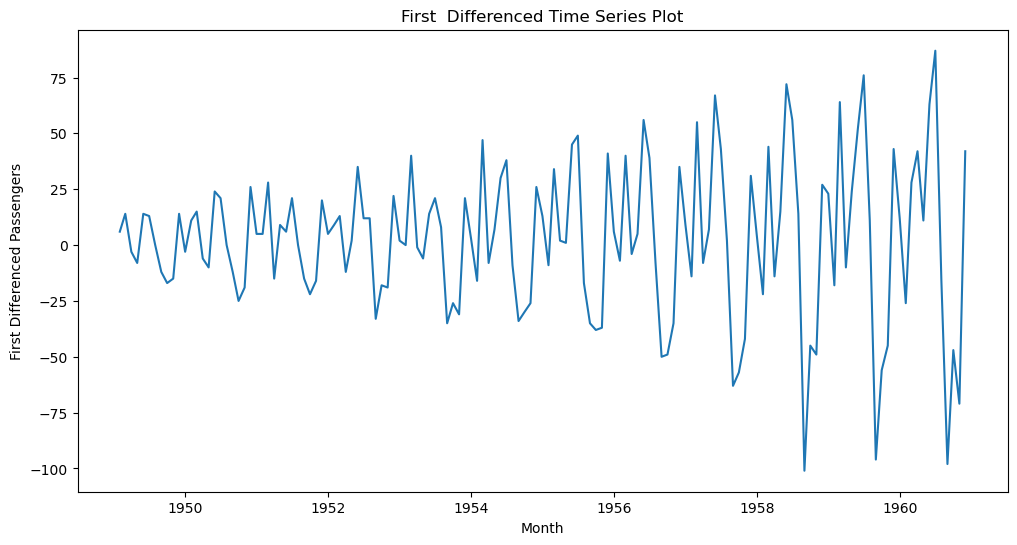

In [28]:
# Plot the first differenced data
plt.figure(figsize=(12, 6))
plt.plot(df['Differenced_Visits'])
plt.title('First  Differenced Time Series Plot')
plt.xlabel('Month')
plt.ylabel('First Differenced Passengers')
plt.show()

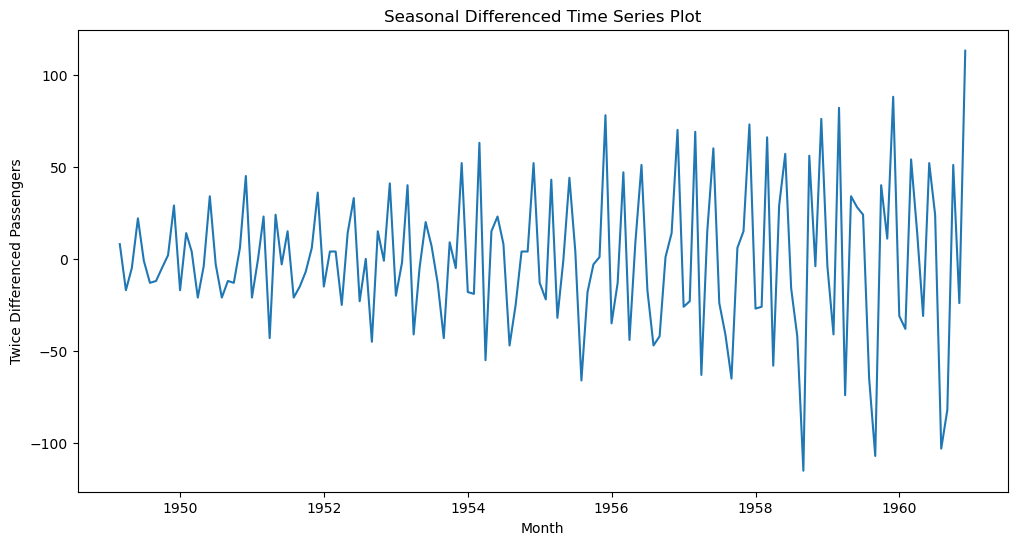

In [29]:
# Plot the second_diff data
plt.figure(figsize=(12, 6))
plt.plot(df['twice_differenced'])
plt.title('Seasonal Differenced Time Series Plot')
plt.xlabel('Month')
plt.ylabel('Twice Differenced Passengers')
plt.show()

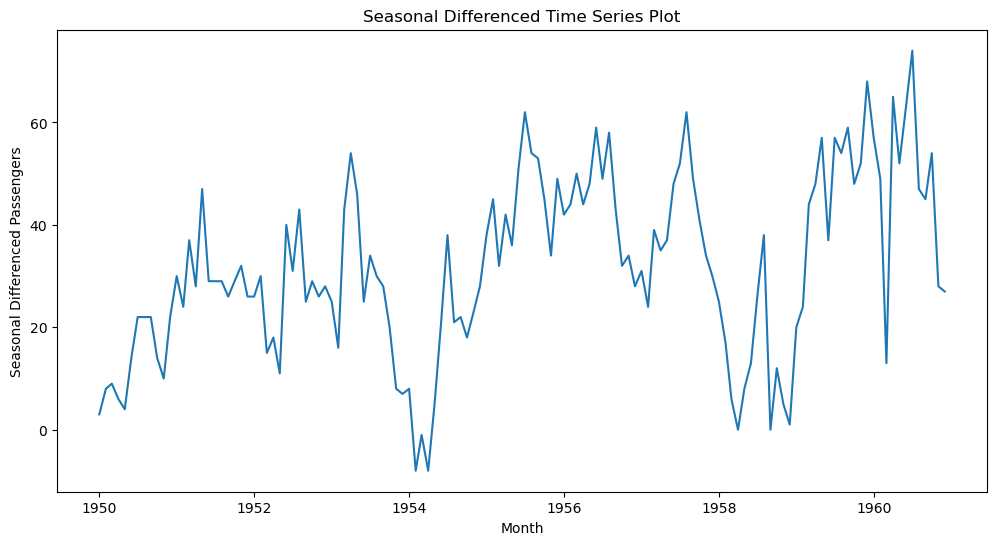

In [30]:
# Plot the seasonal_diff data
plt.figure(figsize=(12, 6))
plt.plot(df['Seasonal_Diff'])
plt.title('Seasonal Differenced Time Series Plot')
plt.xlabel('Month')
plt.ylabel('Seasonal Differenced Passengers')
plt.show()

### Question 2.2

<Figure size 1200x600 with 0 Axes>

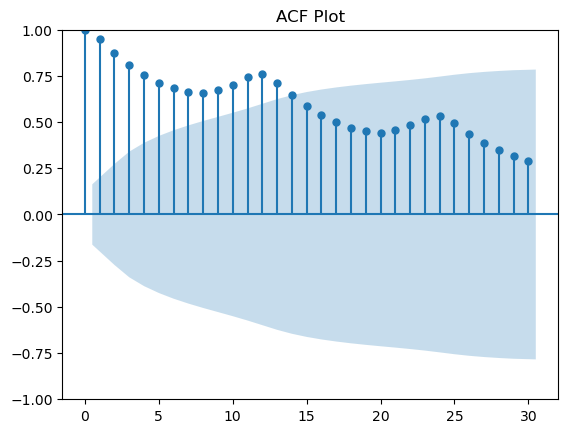

In [31]:
#ACF plot of original data
plt.figure(figsize=(12, 6))
plot_acf(df['Visits'], lags=30)
plt.title('ACF Plot')
plt.show()


<Figure size 1200x600 with 0 Axes>

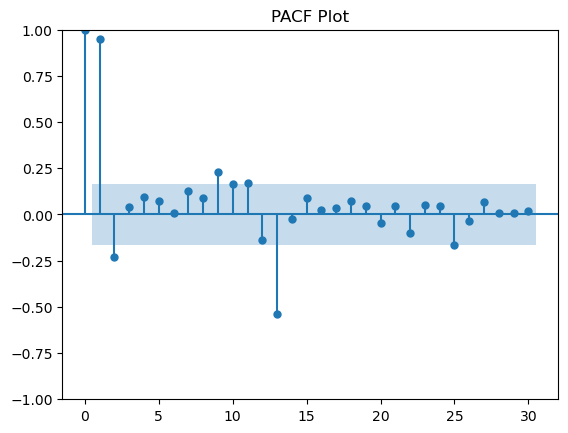

In [32]:
plt.figure(figsize=(12, 6))
plot_pacf(df['Visits'], lags=30)
plt.title('PACF Plot')
plt.show()

<Figure size 1200x600 with 0 Axes>

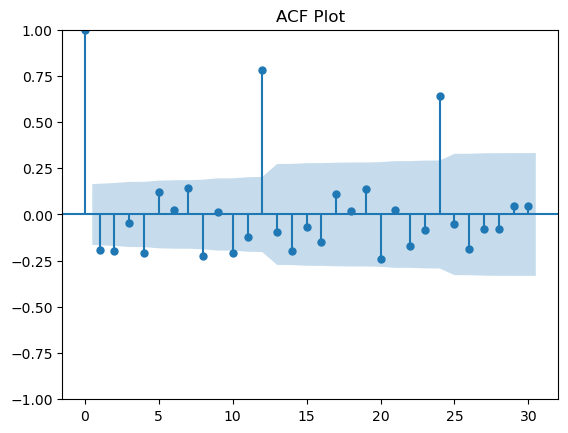

In [33]:
#ACF plot of original data
plt.figure(figsize=(12, 6))
plot_acf(clean_series2, lags=30)
plt.title('ACF Plot')
plt.show()


<Figure size 1200x600 with 0 Axes>

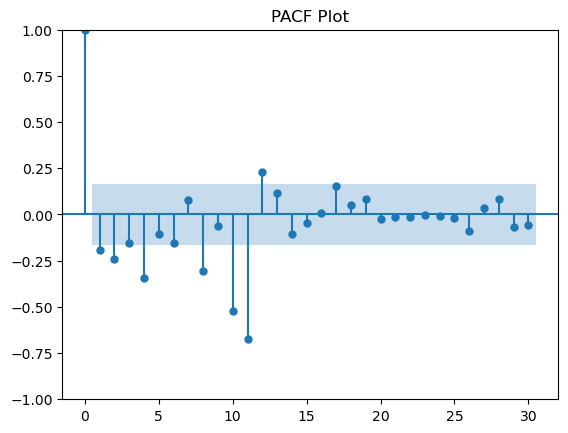

In [34]:
plt.figure(figsize=(12, 6))
plot_pacf(clean_series2, lags=30)
plt.title('PACF Plot')
plt.show()

<Figure size 1200x600 with 0 Axes>

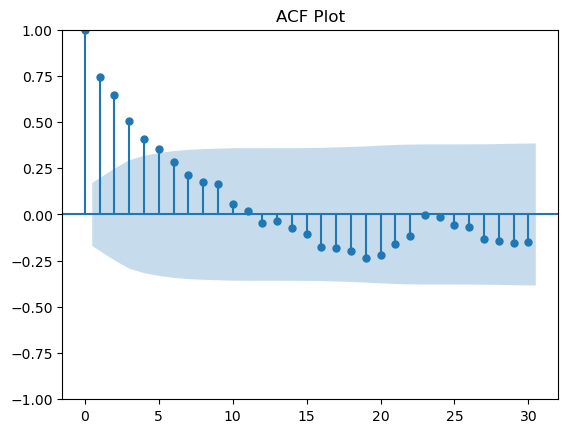

In [35]:
#ACF plot of original data
plt.figure(figsize=(12, 6))
plot_acf(clean_seasonal_diff, lags=30)
plt.title('ACF Plot')
plt.show()


<Figure size 1200x600 with 0 Axes>

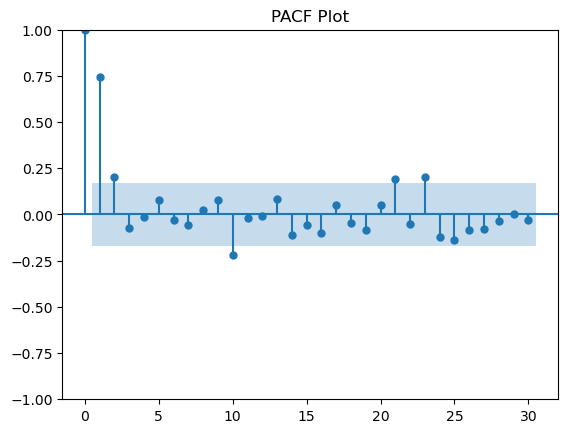

In [36]:
plt.figure(figsize=(12, 6))
plot_pacf(clean_seasonal_diff, lags=30)
plt.title('PACF Plot')
plt.show()

In [37]:
import pmdarima as pm
model = pm.auto_arima(
    df['Visits'],
    seasonal = True,
    m=12,
    stepwise = True,
    trace = True,
    suppress_warnings=True,
    error_actiona='ignore'
)

print(model.summary())

C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\z

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=2.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.06 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.20 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.34 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=1.29 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.43 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=1.25 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.20 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.41 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.99 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=1.08 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=2.28 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.17 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.14 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,1,0)[12]             : AIC=1019.084, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.10 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,1,0)[12]             : AIC=1023.666, Time=0.18 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,1,0)[12]             : AIC=1021.083, Time=0.86 sec


C:\Users\zinya\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=1.18 sec

Best model:  ARIMA(2,1,1)(0,1,0)[12]          
Total fit time: 14.265 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Mon, 03 Nov 2025   AIC                           1017.847
Time:                                     09:22:04   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [39]:
# Split data into train and test sets
train = df[:-12]  
test= df[-12:]

In [43]:
model_arima = SARIMAX(train['Visits'], order=(2,1,1), seasonal_order=(0,1,0,12))
results = model_arima.fit()
print(results.summary())

C:\Users\zinya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\zinya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\zinya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\zinya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                              Visits   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -447.483
Date:                             Mon, 03 Nov 2025   AIC                            902.967
Time:                                     09:44:17   BIC                            914.083
Sample:                                 01-01-1949   HQIC                           907.481
                                      - 12-01-1959                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5253      0.929     -0.566      0.572      -2.345       1.295
ar.L2          0.0110      

In [54]:
# Forecast for test period (12 months)
forecast_test_sarima = results.forecast(steps=12)
forecast_test_sarima

1960-01-01    425.135148
1960-02-01    408.815435
1960-03-01    471.901434
1960-04-01    462.399947
1960-05-01    486.128076
1960-06-01    538.276345
1960-07-01    614.195484
1960-08-01    625.239583
1960-09-01    529.215533
1960-10-01    473.228649
1960-11-01    428.221496
1960-12-01    471.225397
Freq: MS, Name: predicted_mean, dtype: float64

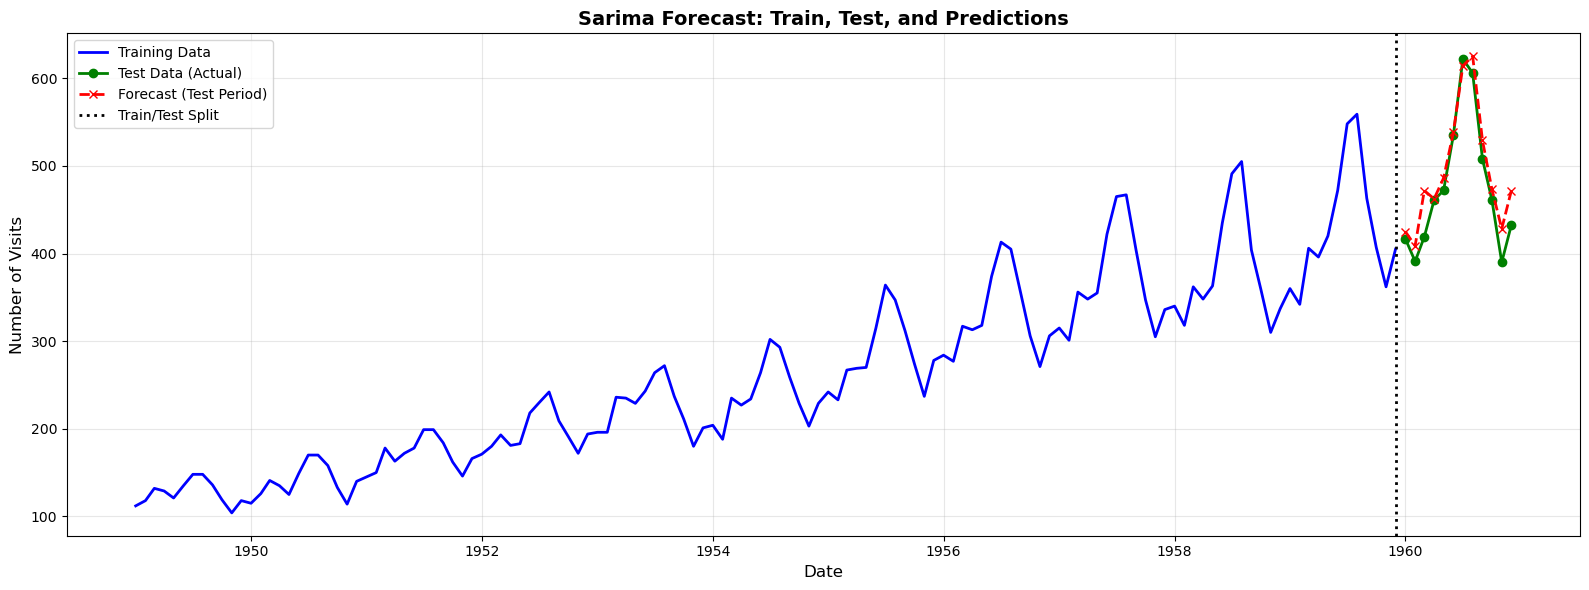

In [51]:
#Full view with train, test, and forecast
plt.figure(figsize=(16, 6))
plt.plot(train.index, train['Visits'], label='Training Data', linewidth=2, color='blue')
plt.plot(test.index, test['Visits'], label='Test Data (Actual)', linewidth=2, color='green', marker='o')
plt.plot(test.index, forecast_test_sarima, label='Forecast (Test Period)', linewidth=2, color='red', linestyle='--', marker='x')
plt.axvline(x=train.index[-1], color='black', linestyle=':', linewidth=2, label='Train/Test Split')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Visits', fontsize=12)
plt.title('Sarima Forecast: Train, Test, and Predictions', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The SARIMA  model clearly follows the upward trend and seasonal fluctuations throughout the training period. SARIMA correctly models trend and seasonality underfits the magnitude. SARIMA forecasts underestimates peak months and overestimate the drop. SARIMA captures the pattern. SARIMA effectively models both trend and seasonality.


In [47]:
# Residual analysis
residuals_sarima_train = train['Visits'] - results.fittedvalues
residuals_sarima_test = test['Visits'] - forecast_test_sarima

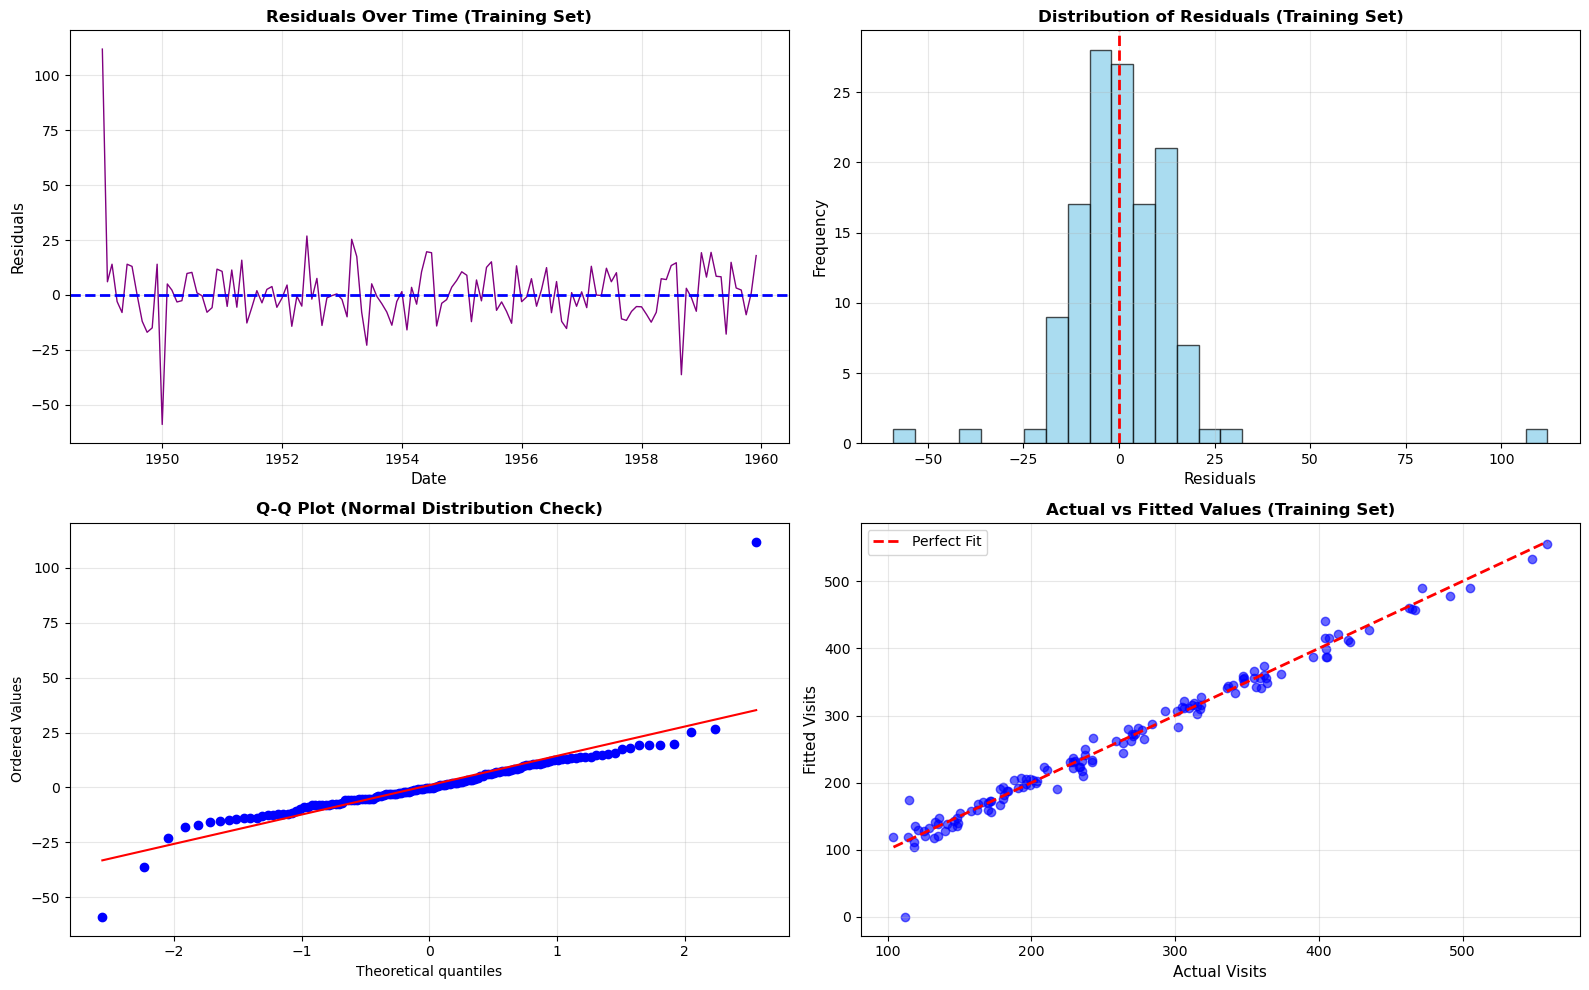

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
#  Residuals over time (Training)
axes[0, 0].plot(train.index, residuals_sarima_train, color='purple', linewidth=1)
axes[0, 0].axhline(y=0, color='blue', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Residuals Over Time (Training Set)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histogram of residuals
axes[0, 1].hist(residuals_sarima_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Residuals (Training Set)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

#Q-Q Plot
from scipy import stats
stats.probplot(residuals_sarima_train, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normal Distribution Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Actual vs Fitted (Training)
axes[1, 1].scatter(train['Visits'], results.fittedvalues, alpha=0.6, color='blue')
axes[1, 1].plot([train['Visits'].min(), train['Visits'].max()], 
                [train['Visits'].min(), train['Visits'].max()], 
                'r--', linewidth=2, label='Perfect Fit')
axes[1, 1].set_xlabel('Actual Visits', fontsize=11)
axes[1, 1].set_ylabel('Fitted Visits', fontsize=11)
axes[1, 1].set_title('Actual vs Fitted Values (Training Set)', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Residuals over time
Residuals fluctuate around zero without a clear pattern. no visible trend or systematic periodicity remaining. Variance seems constant after initial few years. SARIMA model captured most of the trend and seasonality, leaving behind random noise. there is no autocorrelation pattern, suggesting the residuals behave like white noise.

### Distribution of residuals
Histogram is roughly bell-shaped, centered around zero. slight right-tail outlier is visible, but otherwise symmetrical. Residuals are approximately normally distributed.

### Q-Q Plot 
Most points lie closely along the 45 degree reference line. slight deviation in the tails. Residuals follow a near normal distribution, a good sign that model errors are unbiased and well behaved.

### Actual vs Fitted Values
The scatterplot of actual vs fitted values lie almost perfectly along the diagonal. Very tight clustering of points, especially around midrange values.


## Question 2.3

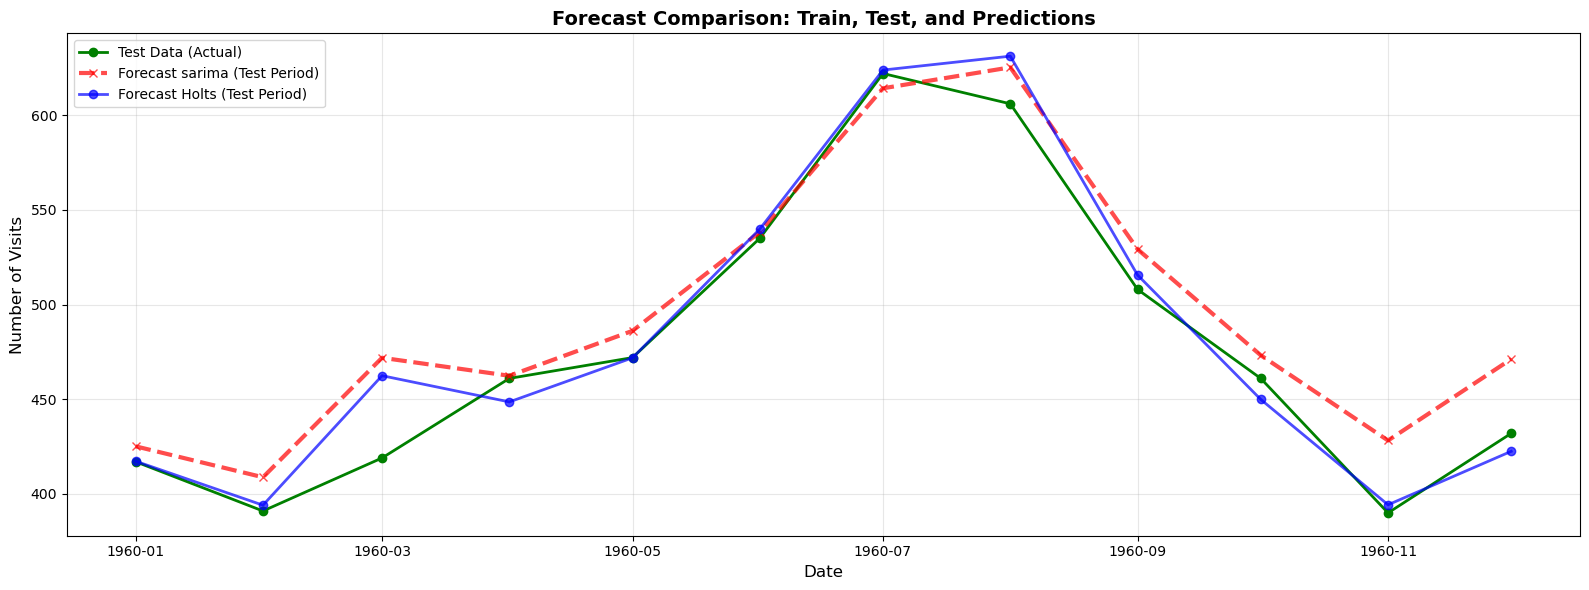

In [61]:
plt.figure(figsize=(16, 6))

plt.plot(test.index, test['Visits'], 
         label='Test Data (Actual)', 
         linewidth=2, color='green', marker='o')

plt.plot(test.index, forecast_test_sarima, 
         label='Forecast sarima (Test Period)', 
         linewidth=3, color='red', linestyle='--', marker='x', alpha=0.7)

plt.plot(test.index, forecast_test, 
         label='Forecast Holts (Test Period)', 
         linewidth=2, color='blue', linestyle='-', marker='o', alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Visits', fontsize=12)
plt.title('Forecast Comparison: Train, Test, and Predictions', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Both models correctly follow the overall upward trend, the holt's model captures the shape and turning points of the data more closely.
The SARIMA model slightly overestimates near june-july and underestimates the drop after. The Holt Winters model adapts better to seasonal variations, while SARIMA struggles a bit with turning points

Around june-july 1960 , Holt Winters matches the actual peak almost perfectly, SARIMA forecast has a wider swing overshooting the recovery period. The Holt-Winters model more accurately captures both the magnitude and direction of changes in the test data.

SARIMA forecasts appear slightly smoother and slower to react to changes.  Holt-Winters responds faster to short term movements, giving a more realistic month-to month variation.

Holt-Winters is more responsive and accurate in short horizons. Holt-Winters model is better suited for this dataset.